학습 목표

- 이미 정제된 10개 클래스의 숫자 손글씨 데이터를 분류하는 classifier 만들기
- 정제되지 않은 웹캠 사진으로부터 데이터 만들기
- 흑백 사진이 아닌 컬러 사진을 학습하는 classifier 만들기
- 분류하고자 하는 클래스의 개수를 조절하기

<br>

# 1. Mnist dataset 손글씨 분류

## 1.1 데이터 준비하기

MNIST 숫자 이미지 데이터셋을 TensorFlow에서 불러오고, 학습용 데이터의 개수 확인하기

- **TensorFlow / Keras**: 딥러닝 모델을 구성하고 학습하기 위한 주요 프레임워크이다. Keras는 TensorFlow 위에서 동작하는 고수준 API로, 모델 설계가 간편하다.
- **MNIST**: 손글씨 숫자(0~9)로 구성된 이미지 데이터셋으로, 딥러닝 입문 실습에 가장 많이 사용되는 데이터이다.
    - 총 70,000개의 28x28 픽셀 grayscale 이미지로 구성됨
        - 학습용: 60,000장
        - 테스트용: 10,000장
- `mnist.load_data()`: 데이터셋을 `(x_train, y_train), (x_test, y_test)` 형식으로 반환한다.
    - `x_train`: 학습 이미지 (28x28 크기의 넘파이 배열)
    - `y_train`: 학습 이미지 각각에 대한 정답(타겟 레이블)을 담고 있는 1차원 배열
    - MNIST 데이터셋의 X항목은 이미지 데이터를 담은 행렬(matrix)
- `print(len(x_train))`: 전체 훈련 이미지의 개수를 확인합니다. (결과는 보통 60000)

In [ ]:
# TensorFlow와 Keras 불러오기 (딥러닝 모델 구축 및 학습용)
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import os

# TensorFlow 버전 출력 (환경 확인용)
print(tf.__version__)

# Keras 내장 MNIST 데이터셋 불러오기
mnist = keras.datasets.mnist

# 학습 데이터와 테스트 데이터를 각각 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 학습용 이미지 수 출력
print(len(x_train))

2.18.0
60000


In [ ]:
print(y_train[1])  # 학습용 데이터에서 두 번째 이미지의 정답 숫자 확인

0


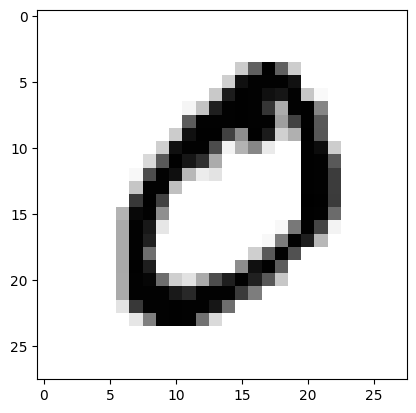

In [ ]:
# x_train[1]: 두 번째 손글씨 이미지의 픽셀 값 (28x28 배열)
# cmap=plt.cm.binary: 흑백 컬러맵을 사용하여 시각화
plt.imshow(x_train[1],cmap=plt.cm.binary)
plt.show()

- 지정한 인덱스의 학습 이미지와 그에 해당하는 실제 숫자 라벨을 시각화하고 출력

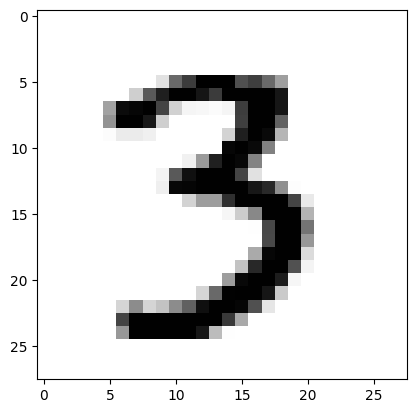

10001 번째 이미지의 숫자: 3


In [ ]:
# 시각화할 이미지의 인덱스 지정 (0 ~ 59999 범위)
index = 10000

# 지정한 인덱스에 해당하는 손글씨 이미지를 흑백으로 출력
plt.imshow(x_train[index], cmap=plt.cm.binary)
plt.show()

# 해당 인덱스 이미지의 실제 숫자 라벨 출력
print((index+1), '번째 이미지의 숫자:', y_train[index])

<br>

MNIST 이미지 데이터의 크기와 픽셀 범위 확인
- (샘플 수, 이미지 크기)

In [ ]:
print(x_train.shape)  # (60000, 28, 28) → 60,000개의 28x28 흑백 이미지

(60000, 28, 28)


In [ ]:
print(x_test.shape)  # (10000, 28, 28) → 10,000개의 테스트 이미지

(10000, 28, 28)


In [ ]:
# 픽셀값의 범위 확인 (MNIST는 0~255 사이의 정수값으로 구성됨)
print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train))

최소값: 0  최대값: 255


<br>

2차원 이미지 데이터를 1차원 벡터로 평탄화한 뒤, 이를 다시 원래 이미지처럼 28픽셀 단위로 콘솔에 출력하여 확인

- 평탄화 이해: Dense 신경망의 입력으로 1D 벡터가 필요하다

- 시각적 확인: 평탄화 후에도 데이터를 해석할 수 있다

- 전처리 기반 이해: 이후 Flatten() 레이어와 연결됨



In [ ]:
"""
- flatten()
  : 다차원 배열을 1차원 배열로 펼치는 함수
  : CNN을 사용하지 않는 전통적인 신경망(MLP)에서는 2D 이미지 데이터를 1D로 평탄화한 후 입력으로 사용
  e.g., 28x28 = 784개의 픽셀 → shape = (784,)

- range(0, len(flat), 28)
  : flat은 총 784개의 원소를 갖고 있고, 이는 28픽셀 × 28줄이라는 구조를 뜻함
  : 반복문을 통해 28개씩 묶어 한 줄에 출력함으로써 이미지 형태를 유지한 채 콘솔로 시각화

- f'{val:3}'
  : 각 픽셀 값을 폭 3칸으로 고정해 깔끔하게 출력하기 위한 포맷팅입니다.
  : 픽셀 값은 0~255 사이이므로 3자리면 충분
"""

# 학습용 이미지 중 두 번째 이미지 (28x28)를 평탄화하여 1차원 배열로 변환
flat = x_train[1].flatten()  # 2D (28, 28) → 1D (784,)

# 평탄화된 벡터를 다시 이미지 형태처럼 출력: 28개씩 끊어서 한 줄에 출력
for i in range(0, len(flat), 28):
    # 각 픽셀 값을 3자리 정수 형식으로 출력하고, 공백으로 구분하여 줄 출력
    print(' '.join(f'{val:3}' for val in flat[i:i+28]))

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253 159  50   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252 252 237   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239 233 252  57   6   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202  84 252 253 122   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 253 252 252  96 189 253 167   0   0   0   0 

이 784 (=28x28)개의 숫자는 딥러닝 모델의 입력 벡터가 된다. 모델은 이 숫자들을 패턴으로 해석하여 0~9 중 어떤 숫자인지를 예측하게 된다. CNN(합성곱 신경망)을 사용할 경우에는 평탄화 전의 28x28 형태 그대로 사용하지만, 전통적인 MLP(Dense 기반 네트워크)는 이와 같이 1차원 입력을 필요로 한다.

<br>

데이터를 0~1 사이의 실수로 정규화(Normalization)

- 딥러닝 모델에서는 작은 입력값일수록 학습 안정성과 수렴 속도가 향상됨
- 이는 특히 활성화 함수(ReLU, sigmoid 등)의 입력 범위와 관련이 깊음

In [ ]:
# 데이터를 0~1 사이로 정규화 → 모델 학습의 효율성과 안정성 향상
# 이후 학습 및 평가에 x_train_norm, x_test_norm 사용
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm))

최소값: 0.0  최대값: 1.0


<br>

## 1.2 딥러닝 네트워크 설계하기

MNIST 손글씨 숫자 이미지를 분류하기 위힌 **합성곱 신경망(CNN)** 구성
- Sequential() 모델: 위애서 아래로 층을 순차적으로 쌓는 간단한 방식의 딥러닝 모델

<br>

- Conv2D, MaxPooling2D: 먼저 이미지에서 특징을 뽑아내는 단계:
- Flatten: 그다음 계산하기 쉬운 형태로 바꾸는 단계
- Dense: 마지막으로 숫자를 예측하는 단계

| 구성요소                | 설명                                                                |
| ------------------- | ----------------------------------------------------------------- |
| Conv2D          | 필터를 이미지에 슬라이딩하여 로우레벨 특징(모서리, 질감) 추출. 필터 수가 많을수록 다양한 패턴을 포착 가능 |
| MaxPooling2D    | 특징맵의 크기를 줄여 연산 효율 향상, 과적합 방지, 위치 불변성 부여               |
| Flattern         | CNN의 출력(2D)을 Dense에 연결하기 위해 1D 벡터로 변환                         |
| Dense           | 노드 간 모든 연결을 통해 정보 통합 및 추론 수행, ReLU는 활성화 함수                    |
| Dense + Softmax | 최종 10개의 클래스 확률을 출력하는 분류용 출력층                              |

<br>

Sequential 모델
- 층을 순서대로 쌓는 방식
- 복잡한 구조(e.g., 여러 입력, skip connection 등)는 못하지만, 기본적인 CNN, MLP에는 적합

CNN(합성곱 신경망)의 구조
- CNN은 이미지나 시계열과 같이 공간 정보가 중요한 데이터에 적합
- 구성 순서
    ```
    Conv → Pooling → (Conv → Pooling) → Flatten → Dense → Output
    ```



In [ ]:
# Sequential 모델 생성: 층을 순차적으로 추가할 수 있는 기본 구조
model=keras.models.Sequential()
# 입력 이미지(28x28, 채널 1)를 받아 3x3 필터 16개로 합성곱 연산 수행
# 활성화 함수로 ReLU 사용 → 비선형성 부여
# 특징 추출 시작 (Edge, 선, 점 등 로우레벨 특징)
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)))
# 2x2 크기의 필터로 MaxPooling → 공간적 크기를 절반으로 줄임
# 연산량 감소 + 과적합 방지 효과
model.add(keras.layers.MaxPool2D(2,2))
# 두 번째 합성곱 층: 더 많은 필터(32개)로 더 복잡한 패턴 추출
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
# 다시 2x2로 MaxPooling → 특성맵 크기 감소, 추상화 강화
model.add(keras.layers.MaxPooling2D((2,2)))
# 다차원(2D) 특성맵을 1차원 벡터로 변환 → Fully Connected Layer로 전달
model.add(keras.layers.Flatten())
# 은닉층(Dense): 노드 32개, ReLU 사용 → Flatten한 특징 벡터를 추상화
model.add(keras.layers.Dense(32, activation='relu'))
# 출력층: 10개 노드 (0~9 숫자 클래스), Softmax로 각 클래스 확률 출력
model.add(keras.layers.Dense(10, activation='softmax'))

# 총 Layer 개수 출력
#  - 총 7개: Conv2D, MaxPool, Conv2D, MaxPool, Flatten, Dense, Dense)
print('Model에 추가된 Layer 개수: ', len(model.layers))

Model에 추가된 Layer 개수:  7


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<br>

딥러닝 모델의 구조 요약 정보 확인

- Layer(type)
    - 레이어 이름과 종류 (Conv2D, Dense 등)
- Output Shape
    - 해당 레이어의 출력 텐서 형태 (배치 차원 None은 입력에 따라 결정됨)
- Param #
    - 해당 레이어의 학습 가능한 파라미터 개수 (weights + biases)

In [ ]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,762 (120.16 KB)

 Trainable params: 30,762 (120.16 KB)

 Non-trainable params: 0 (0.00 B)


이 모델은 28x28 이미지에서 두 번의 합성곱-풀링을 거친 뒤, 완전연결층(Dense)을 통해 10개의 숫자 클래스로 분류한다. 전체 3만여 개의 파라미터를 학습하며, 간단한 구조로 MNIST 분류에 적합하다.

<br>

| 층 | 층 이름           | 출력 형태 | 파라미터 수  | 쉬운 설명                                                                    |
| ---- | -------------- | -------------------- | ------- | ------------------------------------------------------------------------ |
| 1    | `Conv2D`       | `(26, 26, 16)`       | 160개    | 3x3 크기 필터 16개가 이미지 특징을 추출합니다. 이미지가 약간 작아진 이유는 경계처리(padding)를 안 했기 때문입니다. |
| 2    | `MaxPooling2D` | `(13, 13, 16)`       | 0개      | 특징을 반으로 줄여 계산량을 줄이고 중요한 정보만 남깁니다.                                        |
| 3    | `Conv2D`       | `(11, 11, 32)`       | 4,640개  | 이번엔 32개의 필터로 더 많은 특징을 뽑아냅니다.                                             |
| 4    | `MaxPooling2D` | `(5, 5, 32)`         | 0개      | 또 한 번 줄여서 더 간단하게 만듭니다.                                                   |
| 5    | `Flatten`      | `(800,)`             | 0개      | 5×5×32개의 숫자를 한 줄로 펼칩니다. 즉, 800차원 벡터가 됩니다.                                |
| 6    | `Dense`        | `(32,)`              | 25,632개 | 800개 숫자를 받아서 32개의 숫자로 압축합니다.                                             |
| 7    | `Dense`        | `(10,)`              | 330개    | 마지막으로 0\~9 중 어떤 숫자인지 확률로 나타냅니다. softmax 함수가 쓰입니다.                        |

<br>




In [ ]:
print(x_train.shape)

(60000, 28, 28)


<br>

## 1.3 딥러닝 네트워크 학습시키기

CNN 모델에 입력하기 위해 학습/테스트 이미지를 4차원 형태 (샘플 수, 28, 28, 1)로 reshape(변환)
- CNN은 4차원 입력을 요구함
- 따라서 3차원 배열 (60000, 28, 28) → 4차원 (60000, 28, 28, 1)로 바꾸는 작업이 필요함







In [ ]:
# reshape 전 이미지 데이터 형태 출력 (정규화된 상태)
print(f'Before Reshape - x_train_norm shape: {x_train_norm.shape}')  # 예: (60000, 28, 28)
print(f'Before Reshape - x_test_norm shape: {x_test_norm.shape}')    # 예: (10000, 28, 28)

# CNN 모델 입력을 위한 4차원 텐서로 변환
# -1: 샘플 수를 자동으로 계산, 28x28: 이미지 크기, 1: 채널 수(흑백 이미지)
x_train_reshaped = x_train_norm.reshape(-1, 28, 28, 1)
x_test_reshaped = x_test_norm.reshape(-1, 28, 28, 1)

# reshape 후 이미지 데이터 형태 출력
print(f'After Reshape - x_train_reshaped shape: {x_train_reshaped.shape}')  # 예: (60000, 28, 28, 1)
print(f'After Reshape - x_test_reshaped shape: {x_test_reshaped.shape}')

Before Reshape - x_train_norm shape: (60000, 28, 28)
Before Reshape - x_test_norm shape: (10000, 28, 28)
After Reshape - x_train_reshaped shape: (60000, 28, 28, 1)
After Reshape - x_test_reshaped shape: (10000, 28, 28, 1)


<br>

x_train 학습 데이터로 딥러닝 네트워크를 학습
- CNN 모델을 컴파일하고, 10번(epoch) 동안 학습 데이터를 이용해 모델을 학습시킴
- 각 학습이 진행됨에 따라 epoch 별로 어느 정도 인식 정확도(accuracy)가 올라가는지 확인할 수 있음

In [ ]:
# 모델 컴파일 (학습을 위한 설정)
model.compile(
    optimizer='adam',                        # Adam: 학습률을 자동으로 조정해주는 최적화 알고리즘
    loss='sparse_categorical_crossentropy',  # 다중 클래스 분류에서 정수 레이블을 사용할 때 적합한 손실 함수
    metrics=['accuracy']                     # 모델 평가 지표로 정확도(accuracy) 사용
)

# 모델 학습 수행
#  - x_train_reshaped: (60000, 28, 28, 1) → CNN 입력 형식에 맞춘 학습 데이터
#  - y_train: 정답 레이블 (0~9 정수)
#  - epochs=10: 전체 데이터를 10번 반복하여 학습
model.fit(x_train_reshaped, y_train, epochs=10)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.8734 - loss: 0.4233
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.9789 - loss: 0.0696
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.9852 - loss: 0.0472
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 19ms/step - accuracy: 0.9882 - loss: 0.0375
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9908 - loss: 0.0289
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9919 - loss: 0.0247
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 43s 18ms/step - accuracy: 0.9928 - loss: 0.0209
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.9941 - loss: 0.0174
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9952 - loss: 0.0138
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9959 - loss: 0.0120


손실값(loss)은 계속 감소하고, 정확도(accuracy)는 거의 99.7%까지 증가함
- 학습 데이터에 대해서는 거의 완벽하게 예측할 수 있는 상태에 도달했음을 의미

⇒ 학습 정확도가 높다고 해서 테스트셋에서도 성능이 보장되는 건 아님. 과적합 여부를 확인하려면 model.evaluate() 결과도 함께 봐야 함

⇒ History 객체(`<keras.src.callbacks.history.History at 0x...>`)는 학습 이력을 담고 있어, 나중에 history.history로 시각화도 가능


<br>

## 1.4 테스트 데이터로 성능 확인

학습된 모델을 테스트 데이터에 대해 평가하여 손실(loss)과 정확도(accuracy) 확인



In [ ]:
# 테스트 데이터셋을 이용해 모델 성능 평가
#  - x_test_reshaped: CNN 입력 형식에 맞게 reshape된 테스트 이미지 (10000, 28, 28, 1)
#  - y_test: 실제 정답 라벨 (0~9)
#  - verbose=2: 평가 과정에서 한 줄 요약 출력
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)

# 테스트 결과 출력
print(f'test_loss: {test_loss}')           # 손실값 (작을수록 좋음)
print(f'test_accuracy: {test_accuracy}')   # 정확도 (클수록 좋음)

313/313 - 2s - 6ms/step - accuracy: 0.9857 - loss: 0.0435
test_loss: 0.04353205859661102
test_accuracy: 0.9857000112533569


테스트 데이터에 대한 인식 정확도(accuracy)는 0.9857로 소폭 하락했다. 학습할 때마다 test_loss, test_accuracy 도 변동된다.

위 MNIST 데이터셋 참고문헌을 보면 학습용 데이터와 시험용 데이터의 손글씨 주인이 다른 것을 알 수 있다. 즉, 한 번도 본 적이 없는 필체의 손글씨가 섞여 있을 가능성이 높다. 인식률이 떨어지는 것은 어느 정도 예상 가능한 일이다.



<br>

학습된 모델이 테스트 데이터를 입력받아 숫자를 추론한 결과 출력
- 모델이 출력한 확률 분포와, 가장 가능성이 높은 예측 클래스, 실제 정답을 비교



In [ ]:
# 테스트 이미지에 대해 예측 수행
# : 각 이미지에 대해 0~9 클래스별 확률(예측 결과) 반환
# : (10000, 10) 형태의 배열이 출력
#   → 각 행은 10개의 숫자(0~9)에 대한 확률값
predicted_result = model.predict(x_test_reshaped)

# 확률 배열(예측 결과) 중 가장 높은 확률값을 가진 클래스 인덱스 반환
predicted_labels = np.argmax(predicted_result, axis=1)  # axis=1 → 각 행(이미지)에 대해 최대값의 인덱스 선택

# 예측 결과를 직접 확인하기 위한 인덱스 설정
idx = 0

# 모델이 출력한 0~9 숫자에 대한 확률값 배열 출력 → 벡터 형태
print('model.predict() 결과: ', predicted_result[idx])
# 모델이 가장 가능성 높게 예측한 클래스 번호 출력
print('model이 추론한 가장 가능성이 높은 결과: ', predicted_labels[idx])
# 실제 정답 레이블 출력
print('실제 데이터의 라벨: ', y_test[idx])

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
model.predict() 결과 :  [3.19225819e-07 1.06489765e-07 1.21569219e-05 5.04783338e-06
 1.20160564e-07 1.96726347e-07 6.35414013e-11 9.99981701e-01
 4.14569357e-08 2.43128085e-07]
model이 추론한 가장 가능성이 높은 결과 :  7
실제 데이터의 라벨 :  7


예측 값이 일치하는지 확인
- 테스트셋의 특정 이미지(x_test[idx]) 시각화하여 예측 값이 맞는지 확인

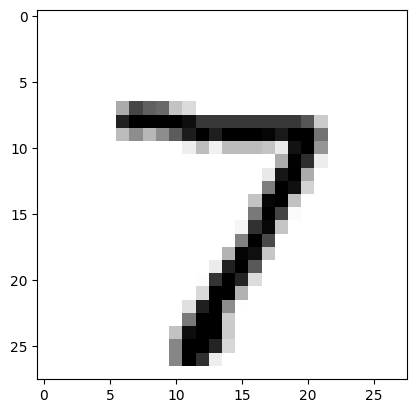

In [ ]:
plt.imshow(x_test[idx],cmap=plt.cm.binary)
plt.show()

<br>

모델의 예측 오류 분석

- 모델이 잘못 예측한 이미지 중 일부 시각화 및 결과 출력
- 모델이 어떤 데이터에서 실수하는지, 왜 잘못 판단했는지를 확인해야 모델 개선 가능
    - 직접 이미지와 예측 결과를 비교함으로써 모델이 오해한 패턴 추적

예측확률분포: [2.9701886e-07 1.6675827e-03 5.6501359e-01 4.6994388e-03 3.0292587e-05
 1.0023670e-06 3.9660527e-08 4.2849964e-01 8.8016124e-05 1.4242288e-07]
라벨: 7, 예측결과: 2


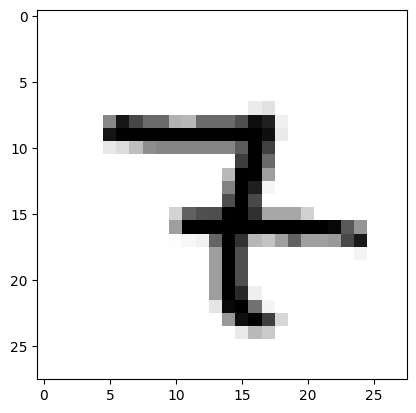

예측확률분포: [3.2177960e-04 6.5013260e-04 6.3204585e-04 8.1186045e-08 7.4247694e-01
 1.0653454e-03 2.5479209e-01 8.9303128e-08 2.7894337e-05 3.3442542e-05]
라벨: 6, 예측결과: 4


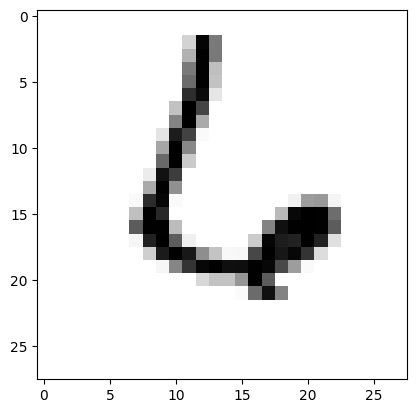

예측확률분포: [9.2997914e-03 2.6330370e-05 2.6148699e-02 3.6747336e-01 2.7850999e-03
 1.4641054e-03 2.2159279e-06 5.5926614e-02 3.2362729e-01 2.1324654e-01]
라벨: 9, 예측결과: 3


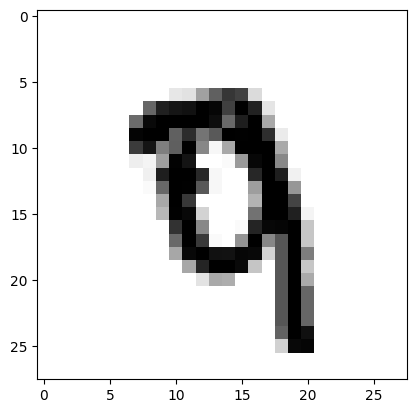

예측확률분포: [1.2043363e-01 1.2991821e-05 5.3771213e-03 4.6109892e-03 1.0061469e-01
 4.0406099e-04 3.4584486e-01 2.0193447e-05 4.2205009e-01 6.3131249e-04]
라벨: 4, 예측결과: 8


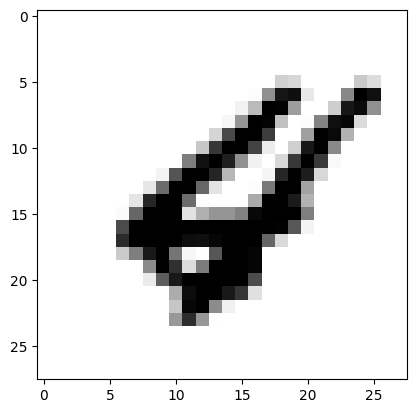

예측확률분포: [4.5596453e-04 4.6776890e-06 5.8306992e-01 1.1569352e-02 3.2546994e-04
 7.0171995e-04 2.6146618e-09 1.6275446e-03 1.6957662e-01 2.3266886e-01]
라벨: 9, 예측결과: 2


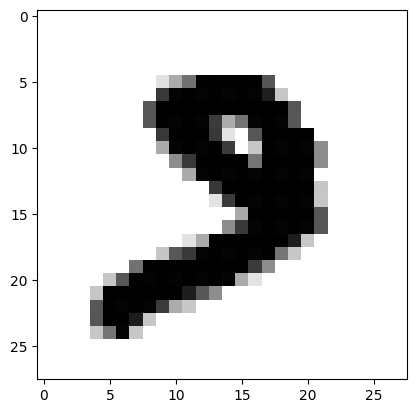

In [ ]:
import random

wrong_predict_list = []  # 모델이 틀린 예측의 인덱스를 저장할 리스트

# 모든 테스트 데이터에서 예측값과 실제값을 비교
for i, _ in enumerate(predicted_labels):
    if predicted_labels[i] != y_test[i]:  # 예측값이 정답과 다르면
        wrong_predict_list.append(i)      # 인덱스를 리스트에 저장

# 잘못 예측한 샘플 중 5개를 랜덤으로 뽑기
samples = random.choices(population=wrong_predict_list, k=5)

# 선택된 각 샘플에 대해 결과 확인 및 이미지 출력
for n in samples:
    print('예측 확률 분포: ' + str(predicted_result[n]))  # 0~9까지 각 숫자일 확률
    print('정답 라벨: ' + str(y_test[n]) + ', 예측 결과: ' + str(predicted_labels[n]))
    plt.imshow(x_test[n], cmap=plt.cm.binary)  # 실제 이미지 출력
    plt.show()

결과를 통해
- 모델 평가: 단순 정확도 외에도 오류 패턴 파악이 가능
- 모델 개선 방향: 어떤 숫자를 자주 틀리는지 → 데이터 증강, 구조 개선 등
- 디버깅: 라벨 자체가 잘못되어 있을 가능성도 눈으로 확인 가능
- 시각적 피드백: 사람에게 직관적인 이미지 기반 해석 제공

<br>

## 1.5 더 좋은 네트워크 만들기

1. 하이퍼파라미터 설정

2. 모델 정의
    - Sequential() 방식

3. 특징 추출 단계
- Conv2D: 이미지를 보고 특징을 뽑는 눈 역할
    - 이미지에서 국소적인 특징(모서리, 곡선 등)을 추출하는 필터 사용
    - activation='relu': 음수를 제거하고, 비선형성을 부여해 신경망 학습에 도움
    - 첫 번째 층은 반드시 input_shape를 명시
- MaxPooling2D: 특징을 압축해서 중요한 것만 남김
    - 필터로 얻은 특성맵의 크기를 줄임으로써 연산량 감소 및 과적합 방지
    - 중요한 정보는 유지하되, 덜 중요한 정보는 버림

4. 분류기 구성
- Flatten: 이미지 구조를 펼쳐서 Dense 층에 전달
    - CNN 계층에서 출력된 3차원 텐서를 1차원 벡터로 펼침
    - Fully Connected Layer(Dense)와 연결하기 위한 전처리 과정
- Dense + ReLU
    - 뉴런 간 모든 연결을 가진 층
    - n_dense=32는 뉴런 수를 의미하며, 일반적으로 특징을 조합해 추상적인 표현을 학습하는 역할
- Dense + Softmax
    - 출력층. 10개의 클래스(숫자 0~9)에 대한 확률값을 출력
    - softmax: 각 클래스의 확률 분포를 보장하여 가장 확률이 높은 클래스를 선택하게 함

5. 모델 요약 정보 출력

6. 모델 컴파일
- optimizer='adam'
    - 확률적 경사 하강법(SGD)의 진화형. 빠른 수렴과 안정된 학습 제공
- loss='sparse_categorical_crossentropy':
    = 라벨이 one-hot encoding이 아니라 정수(0~9)로 되어 있을 때 적합한 다중 클래스 분류 손실 함수
- metrics=['accuracy']:
     - 학습과 테스트에서 정확도(Accuracy)를 추적

7. 모델 학습
- fit(): 모델 학습
    - epochs=10: 전체 데이터를 10번 반복 학습
    - x_train_reshaped: CNN 입력 형식에 맞게 (28, 28, 1)로 reshape된 데이터

8. 모델 평가
- evaluate(): 학습된 모델의 성능을 테스트 데이터셋에서 평가
    - test_loss: 테스트 데이터에서의 평균 손실
    - test_accuracy: 테스트 데이터에서 맞춘 비율



In [ ]:
# 하이퍼파라미터 설정: 모델 구조와 학습 횟수를 조절
n_channel_1=16   # 첫 번째 Conv2D 층의 필터 수 (이미지 특징 추출용)
n_channel_2=32   # 두 번째 Conv2D 층의 필터 수 (더 복잡한 특징 추출)
n_dense=32       # 완전 연결(Dense) 층의 뉴런 수 (최종 분류를 위한 중간층)
n_train_epoch=10  # 전체 데이터를 학습에 사용할 횟수 (epoch 수)

# 모델 정의: 순차적으로 층을 쌓는 방식(Sequential)
model=keras.models.Sequential()
# 첫 번째 합성곱 층: 3x3 필터, ReLU 활성화 함수 사용, 입력 이미지 크기는 28x28x1 (MNIST 같은 흑백 이미지)
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,1)))
# 최대 풀링 층: 2x2 영역에서 가장 큰 값을 선택해 특성 맵 축소 (연산량 줄이기, 중요 정보 유지)
model.add(keras.layers.MaxPool2D(2,2))
# 두 번째 합성곱 층: 더 많은 필터로 복잡한 패턴 학습
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
# 또 한 번의 최대 풀링
model.add(keras.layers.MaxPooling2D((2,2)))
# 특성 맵을 1차원으로 펼쳐서(Dense 층에 입력 가능하도록 변환)
model.add(keras.layers.Flatten())
# 완전 연결층(Dense): 중간 단계에서 중요한 특징 조합
model.add(keras.layers.Dense(n_dense, activation='relu'))
# 출력층: 클래스 수(10개)만큼 뉴런을 만들고, softmax 함수로 확률 분포 출력
model.add(keras.layers.Dense(10, activation='softmax'))

# 모델 구조 출력: 각 층의 이름과 출력 형태, 파라미터 수 등을 보여줌
model.summary()
# 모델 컴파일: 학습에 사용할 최적화 방법(Adam), 손실 함수, 평가 지표 설정
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',  # 정수 레이블에 적합한 분류 손실 함수
             metrics=['accuracy'])

# 모델 학습 시작: 학습 데이터를 n_train_epoch만큼 반복해서 모델에 학습시킴
model.fit(x_train_reshaped, y_train, epochs=n_train_epoch)

# 테스트 데이터로 모델 평가: 손실값과 정확도 측정
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print(f'test_loss: {test_loss} ')
print(f'test_accuracy: {test_accuracy}')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,762 (120.16 KB)

 Trainable params: 30,762 (120.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.8623 - loss: 0.4414
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 18ms/step - accuracy: 0.9782 - loss: 0.0703
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.9848 - loss: 0.0504
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - accuracy: 0.9877 - loss: 0.0388
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9908 - loss: 0.0286
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 42s 17ms/step - accuracy: 0.9919 - loss: 0.0252
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9936 - loss: 0.0202
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9943 - loss: 0.0175
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9952 - loss: 0.0148
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 40s 17ms/step - accuracy: 0.9963 - loss: 0.0117
313/313 - 2s - 6ms/step - accuracy: 0.9859 - loss: 0.0482
test_loss: 0.048223696649074554 
test_acc

<br>
<br>

# 2. 가위바위보 이미지 분류 프로젝트

## 2.1 라이브러리 버전 확인

In [1]:
# 딥러닝 학습을 위한 TensorFlow 및 NumPy 버전 확인
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.18.0
2.0.2


<br>

## 2.2 데이터 준비하기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 압축 해제

!unzip /content/drive/MyDrive/DS/DL/scissor.zip -d 가위
!unzip /content/drive/MyDrive/DS/DL/rock.zip -d 바위
!unzip /content/drive/MyDrive/DS/DL/paper.zip -d 보

Archive:  /content/drive/MyDrive/DS/DL/scissor.zip
 extracting: 가위/0.jpg            
 extracting: 가위/1.jpg            
 extracting: 가위/2.jpg            
 extracting: 가위/3.jpg            
 extracting: 가위/4.jpg            
 extracting: 가위/5.jpg            
 extracting: 가위/6.jpg            
 extracting: 가위/7.jpg            
 extracting: 가위/8.jpg            
 extracting: 가위/9.jpg            
 extracting: 가위/10.jpg           
 extracting: 가위/11.jpg           
 extracting: 가위/12.jpg           
 extracting: 가위/13.jpg           
 extracting: 가위/14.jpg           
 extracting: 가위/15.jpg           
 extracting: 가위/16.jpg           
 extracting: 가위/17.jpg           
 extracting: 가위/18.jpg           
 extracting: 가위/19.jpg           
 extracting: 가위/20.jpg           
 extracting: 가위/21.jpg           
 extracting: 가위/22.jpg           
 extracting: 가위/23.jpg           
 extracting: 가위/24.jpg           
 extracting: 가위/25.jpg           
 extracting: 가위/26.jpg           
 extracting: 가위/27.jpg         

In [4]:
# 이미지 파일을 열고 처리하기 위한 라이브러리(Pillow 패키지의 핵심 모듈)
from PIL import Image  # 이미지 로딩, 리사이징, 색 변환 등에 유용
# 특정 경로 내 파일들을 패턴에 맞게 한 번에 불러올 수 있도록 도와주는 모듈
import glob
# 디렉토리 경로 조작, 파일 존재 여부 확인 등 운영체제 관련 기능 제공
import os

print('PIL 라이브러리 import 완료')

PIL 라이브러리 import 완료


<br>

이미지 resize 함수 정의
- 지정한 폴더 경로에서 .jpg 이미지 파일을 모두 찾아서 모든 이미지를 28x28 픽셀 크기로 리사이즈한 뒤, 원래 파일에 덮어쓰기 저장
- 딥러닝 모델에 이미지를 입력하기 위해 입력 크기를 통일하는 전처리 단계

In [5]:
def resize_images(img_path):
    images = glob.glob(img_path + '/*.jpg')  # 지정 경로에서 .jpg 이미지 파일 목록을 리스트로 가져오기

    print(len(images), ' images to be resized.')  # 총 이미지 수 출력

    # 이미지 크기 리사이징 대상 크기 정의 (CNN 입력 형식에 맞춤)
    target_size = (28, 28)

    for img in images:
        old_img = Image.open(img)  # 이미지 파일 열기 (PIL 객체)
        new_img = old_img.resize(target_size, Image.Resampling.LANCZOS)  # 리사이즈 (LANCZOS는 고급 보간법)
        new_img.save(img, 'JPEG')  # 기존 파일에 덮어쓰기 저장

    print(len(images), ' images resized.')  # 완료된 이미지 수 출력

In [6]:
# 각 클래스별 이미지가 저장된 폴더(가위/바위/보)를 대상으로 resize_images() 함수 호출
# : 모든 이미지를 28x28 크기로 리사이즈하고, 완료 여부 출력
# : CNN 모델의 입력 크기를 통일하기 위한 전처리 작업
image_dir_path = './가위'       # 이미지가 들어있는 폴더 경로 지정
resize_images(image_dir_path)
print('가위 이미지 resize 완료')

image_dir_path = './바위'
resize_images(image_dir_path)
print('바위 이미지 resize 완료')

image_dir_path = './보'
resize_images(image_dir_path)
print('보 이미지 resize 완료')

100  images to be resized.
100  images resized.
가위 이미지 resize 완료
100  images to be resized.
100  images resized.
바위 이미지 resize 완료
100  images to be resized.
100  images resized.
보 이미지 resize 완료


<br>

이미지 데이터 로드 및 전처리 함수 정의

In [26]:
import numpy as np
from sklearn.utils import shuffle  # 데이터 셔플용 유틸리티
import glob
from PIL import Image

def load_data(img_path, folder_names):
    """
    이미지 데이터를 불러오고 라벨을 부여하는 함수
    - 가위: 0, 바위: 1, 보: 2 라벨 부여
      - 테스트용 폴더도 라벨은 동일하게 부여
    - 학습용: folder_names = ['가위', '바위', '보']
    - 테스트용: folder_names = ['가위_test', '바위_test', '보_test']
    """

    img_size = 28       # 이미지 가로, 세로 크기
    color = 3           # RGB 컬러 채널 (3채널)

    # 라벨 맵: 폴더 이름에 따라 라벨 부여
    label_map = {
        '가위': 0, '바위': 1, '보': 2,
        '가위_test': 0, '바위_test': 1, '보_test': 2,
        '가위_test2': 0, '바위_test2': 1, '보_test2': 2,
        '가위_test3': 0, '바위_test3': 1, '보_test3': 2
    }

    # 이미지 배열 및 라벨 배열 초기화
    all_imgs = []
    all_labels = []

    # 지정된 폴더 목록에 대해 이미지 로드
    for folder in folder_names:
        files = glob.glob(os.path.join(img_path, folder, '*.jpg'))
        label = label_map[folder]

        for file in files:
            try:
                img = Image.open(file).resize((img_size, img_size))  # 이미지 로드 및 리사이즈
                img = np.array(img, dtype=np.int32)                  # 배열 변환
                all_imgs.append(img)
                all_labels.append(label)
            except Exception as e:
                print(f"[오류] {file} 읽기 실패:", e)

    print('데이터의 이미지 개수:', len(all_imgs))
    return np.array(all_imgs), np.array(all_labels)  # 이미지 데이터와 라벨 반환

In [8]:
# 함수 실행: 현재 디렉토리 기준으로 데이터 로드
image_dir_path = '.'
(x_train, y_train) = load_data(image_dir_path, ['가위', '바위', '보'])

# 데이터를 무작위로 섞어 모델이 편향 없이 학습할 수 있도록 준비
x_train, y_train = shuffle(x_train, y_train, random_state=42)

# 이미지 정규화: 픽셀 값을 0~1 사이로 변환해 학습 안정화
x_train_norm = x_train / 255.0

# 데이터 형태 확인
print('x_train shape: {}'.format(x_train.shape))  # (샘플 수, 28, 28, 3)
print('y_train shape: {}'.format(y_train.shape))  # (샘플 수,)

데이터의 이미지 개수: 300
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


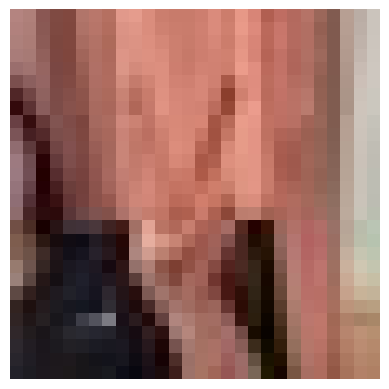

라벨:  0


In [9]:
import matplotlib.pyplot as plt

plt.imshow(x_train[224])         # RGB 이미지 그대로 출력
plt.axis('off')                  # 축 눈금 숨김
plt.show()

# 해당 이미지의 실제 정답 라벨 출력
print('라벨: ', y_train[224])    # 0=가위, 1=바위, 2=보

<br>

## 2.3 딥러닝 네트워크 설계하기

가위/바위/보 이미지 분류를 위한 CNN 모델을 정의
- 입력: 크기 (28x28x3)의 컬러 이미지
- 출력: 3개의 클래스(가위=0, 바위=1, 보=2)에 대한 확률 분포

In [21]:
import tensorflow as tf                    # TensorFlow: 딥러닝 프레임워크
from tensorflow import keras               # Keras: 고수준 API
import numpy as np                         # NumPy: 수치 연산용

# 하이퍼파라미터 설정
n_channel_1 = 16       # 첫 번째 Conv 층의 필터 수
n_channel_2 = 32       # 두 번째 Conv 층의 필터 수
n_dense = 32           # Dense 층 뉴런 수
n_train_epoch = 2     # 학습 epoch 수

# CNN 모델 정의
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3, 3), activation='relu', input_shape=(28, 28, 3)))
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(n_channel_2, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

# 모델 요약 정보 출력: 각 층의 출력 형태, 파라미터 수 확인 가능
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,819 (120.39 KB)

 Trainable params: 30,819 (120.39 KB)

 Non-trainable params: 0 (0.00 B)

<br>

## 2.4 딥러닝 네트워크 학습시키기

정의한 CNN 모델을 컴파일하고 학습시키기
- compile(): 모델 학습 방식(손실 함수, 최적화 알고리즘, 평가 지표 등)을 설정
- 주어진 입력(x_train)과 정답(y_train)을 사용해 모델을 실제로 학습

In [22]:
# 모델 컴파일: 학습 방법과 평가 방식 정의
model.compile(
    optimizer='adam',                        # Adam 옵티마이저: 학습률 자동 조절로 효율적인 학습 수행
    loss='sparse_categorical_crossentropy',  # 정수형 클래스 레이블(0~2)을 사용할 때 적합한 다중 클래스 손실 함수
    metrics=['accuracy']                     # 학습 중 정확도(accuracy)를 측정해 성능 확인
)

# 모델 훈련: 학습 데이터를 사용하여 weight 업데이트 진행
model.fit(
    x_train,              # 학습에 사용할 입력 이미지 데이터
    y_train,              # 각 이미지의 실제 정답 레이블
    epochs=n_train_epoch  # 전체 데이터를 n_train_epoch번 반복해서 학습 (기본값 10)
)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3608 - loss: 10.7289
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7551 - loss: 1.0474


학습 정확도가 지속적으로 상승하고 손실도 꾸준히 감소하면서, 모델이 안정적으로 잘 학습되었음을 보여준다. 특히 5~10 epoch 사이에 급격한 향상과 정교한 미세조정이 이루어진 것을 확인할 수 있다.

<br>

## 2.5 테스트 데이터로 성능 확인

테스트 데이터로 test accuracy 측정하기

In [23]:
# # 압축 해제

# !unzip /content/drive/MyDrive/DS/DL/scissor_test.zip -d 가위_test
# !unzip /content/drive/MyDrive/DS/DL/rock_test.zip -d 바위_test
# !unzip /content/drive/MyDrive/DS/DL/paper_test.zip -d 보_test

테스트용 데이터인 x_test, y_test 만들기

In [24]:
test_image_dir_path = './가위_test'
resize_images(test_image_dir_path)

test_image_dir_path = './바위_test'
resize_images(test_image_dir_path)

test_image_dir_path = './보_test'
resize_images(test_image_dir_path)

# 테스트 데이터 로드 (가위: 0, 바위: 1, 보: 2)
# : 이미지 데이터를 배열로 읽고 라벨링
test_image_dir_path = '.'
(x_test, y_test) = load_data(test_image_dir_path, ['가위_test', '바위_test', '보_test'])
# # 정규화: 이미지 픽셀 값을 0~1 사이로 스케일링
x_test_norm = x_test/255.0
# 테스트 이미지와 라벨 데이터의 shape 출력
print('x_test shape: {}'.format(x_test.shape))  # 이미지 데이터 (개수, 높이, 너비, 채널 수)
print('y_test shape: {}'.format(y_test.shape))  # 정답 라벨 데이터 (개수,)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
데이터의 이미지 개수: 300
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


학습한 CNN 모델을 테스트 데이터셋에 대해 평가
- 모델이 x_test 데이터를 기반으로 예측한 결과와 실제 라벨 y_test를 비교하여
- 손실 함수(loss)와 정확도(accuracy) 출력

In [25]:
# 테스트 데이터로 모델 성능 평가: 손실값, 정확도 return
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print('test_loss: {} '.format(test_loss))
print('test_accuracy: {}'.format(test_accuracy))

10/10 - 0s - 25ms/step - accuracy: 0.3567 - loss: 4.7789
test_loss: 4.778869152069092 
test_accuracy: 0.3566666543483734


학습 데이터에서 성능 (accuracy: 1.0000)
- 모델이 학습 데이터에 과도하게 적합(overfitting) 되어 있을 가능성이 크다는 것을 알 수 있음
- loss 값도 거의 0에 가까워서 모델이 학습 데이터의 모든 이미지를 거의 완벽하게 분류하고 있다는 의미
- 특히 이미지 개수가 많지 않거나, 데이터가 단순하거나, 모델이 너무 복잡한 경우 이런 현상이 발생

테스트 데이터에서 성능 (accuracy: 0.356)
- 일반화 성능 부족
- 학습에서 본 적 없는 데이터에 대해 모델이 잘 예측하지 못하고 있다는 뜻
- loss 값이 크게 나온 것도 모델이 예측을 틀리는 경우가 많다는 의미
- 모델이 너무 복잡하거나 너무 단순해서 적절한 일반화를 하지 못한다고 판단할 수 있음



In [15]:
y_train

array([2, 2, 1, 0, 2, 2, 1, 1, 0, 1, 2, 0, 2, 0, 1, 2, 2, 2, 1, 1, 0, 1,
       2, 2, 1, 0, 2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 2, 1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0,
       0, 2, 0, 1, 1, 1, 2, 1, 1, 2, 0, 0, 0, 2, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 2, 0, 0, 1, 1, 2, 0, 2, 0, 0, 1, 2, 2, 1, 0, 1, 0,
       1, 2, 0, 2, 2, 1, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 1, 1,
       1, 1, 2, 2, 1, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 2, 1, 2, 1,
       2, 2, 2, 0, 1, 0, 2, 1, 0, 0, 0, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 2,
       1, 0, 2, 1, 2, 0, 2, 2, 1, 2, 2, 1, 0, 0, 0, 1, 2, 2, 2, 0, 2, 2,
       0, 2, 0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 1, 2, 0, 0, 2, 0, 0, 2, 1, 0,
       1, 2, 2, 1, 0, 2, 1, 0, 2, 2, 0, 2, 2, 2, 1, 0, 0, 0, 2, 2, 2, 2,
       1, 0, 2, 1, 1, 2, 2, 0, 1, 0, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 2, 0,
       0, 1, 2, 1, 2, 2, 0, 0, 1, 1, 2, 1, 1, 0, 0, 2, 2, 0, 1, 2, 1, 2,
       1, 1, 1, 0, 0, 2, 1, 2, 0, 1, 0, 1, 2, 1])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


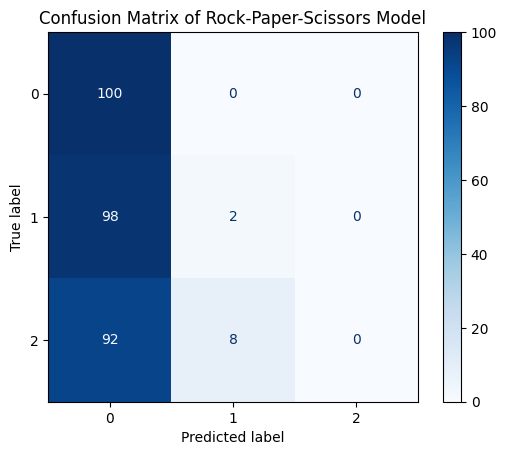

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델이 예측한 클래스 라벨 (확률에서 가장 높은 값 선택)
y_pred = model.predict(x_test_norm)
y_pred_labels = np.argmax(y_pred, axis=1)

# 혼동행렬 계산
cm = confusion_matrix(y_test, y_pred_labels)

class_names = [0, 1, 2]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Rock-Paper-Scissors Model')
plt.show()

In [17]:
# 동일 이미지가 있는지 확인 (픽셀 기준 비교)
overlap_count = 0
for i in range(len(x_test)):
    for j in range(len(x_train)):
        if np.array_equal(x_test[i], x_train[j]):
            overlap_count += 1
print("Train-Test 데이터 중복 개수:", overlap_count)

Train-Test 데이터 중복 개수: 0


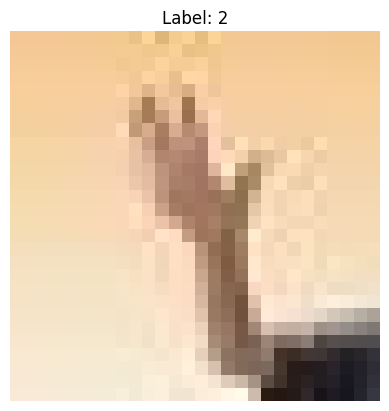

In [18]:
import matplotlib.pyplot as plt

# 확인할 인덱스를 설정
idx = 299

# 이미지 출력
plt.imshow(x_test[idx], cmap=plt.cm.binary)  # 컬러 이미지는 cmap 생략 가능
plt.axis('off')  # 축 없애기
plt.title(f"Label: {y_test[idx]}")
plt.show()

## 추가 테스트

In [16]:
# # 압축 해제

# !unzip /content/drive/MyDrive/DS/DL/scissor_test2.zip -d 가위_test2
# !unzip /content/drive/MyDrive/DS/DL/rock_test2.zip -d 바위_test2
# !unzip /content/drive/MyDrive/DS/DL/paper_test2.zip -d 보_test2

Archive:  /content/drive/MyDrive/DS/DL/scissor_test2.zip
 extracting: 가위_test2/0.jpg      
 extracting: 가위_test2/1.jpg      
 extracting: 가위_test2/2.jpg      
 extracting: 가위_test2/3.jpg      
 extracting: 가위_test2/4.jpg      
 extracting: 가위_test2/5.jpg      
 extracting: 가위_test2/6.jpg      
 extracting: 가위_test2/7.jpg      
 extracting: 가위_test2/8.jpg      
 extracting: 가위_test2/9.jpg      
 extracting: 가위_test2/10.jpg     
 extracting: 가위_test2/11.jpg     
 extracting: 가위_test2/12.jpg     
 extracting: 가위_test2/13.jpg     
 extracting: 가위_test2/14.jpg     
 extracting: 가위_test2/15.jpg     
 extracting: 가위_test2/16.jpg     
 extracting: 가위_test2/17.jpg     
 extracting: 가위_test2/18.jpg     
 extracting: 가위_test2/19.jpg     
 extracting: 가위_test2/20.jpg     
 extracting: 가위_test2/21.jpg     
 extracting: 가위_test2/22.jpg     
 extracting: 가위_test2/23.jpg     
 extracting: 가위_test2/24.jpg     
 extracting: 가위_test2/25.jpg     
 extracting: 가위_test2/26.jpg     
 extracting: 가위_test2/27.

In [17]:
test_image_dir_path = './가위_test2'
resize_images(test_image_dir_path)

test_image_dir_path = './바위_test2'
resize_images(test_image_dir_path)

test_image_dir_path = './보_test2'
resize_images(test_image_dir_path)

# 테스트 데이터 로드 (가위: 0, 바위: 1, 보: 2)
# : 이미지 데이터를 배열로 읽고 라벨링
test_image_dir_path = '.'
(x_test, y_test) = load_data(test_image_dir_path, ['가위_test2', '바위_test2', '보_test2'])
# # 정규화: 이미지 픽셀 값을 0~1 사이로 스케일링
x_test_norm = x_test/255.0
# 테스트 이미지와 라벨 데이터의 shape 출력
print('x_test shape: {}'.format(x_test.shape))  # 이미지 데이터 (개수, 높이, 너비, 채널 수)
print('y_test shape: {}'.format(y_test.shape))  # 정답 라벨 데이터 (개수,)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
데이터의 이미지 개수: 300
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [18]:
# 테스트 데이터로 모델 성능 평가: 손실값, 정확도 return
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print('test_loss: {} '.format(test_loss))
print('test_accuracy: {}'.format(test_accuracy))

10/10 - 0s - 28ms/step - accuracy: 0.3667 - loss: 9.7831
test_loss: 9.783102035522461 
test_accuracy: 0.36666667461395264


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


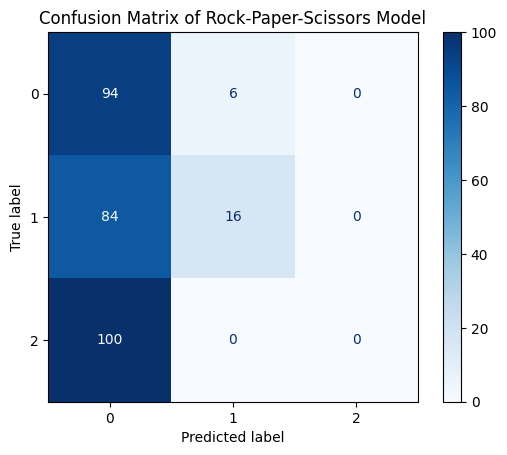

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델이 예측한 클래스 라벨 (확률에서 가장 높은 값 선택)
y_pred = model.predict(x_test_norm)
y_pred_labels = np.argmax(y_pred, axis=1)

# 혼동행렬 계산
cm = confusion_matrix(y_test, y_pred_labels)

class_names = [0, 1, 2]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Rock-Paper-Scissors Model')
plt.show()

In [20]:
# 동일 이미지가 있는지 확인 (픽셀 기준 비교)
overlap_count = 0
for i in range(len(x_test)):
    for j in range(len(x_train)):
        if np.array_equal(x_test[i], x_train[j]):
            overlap_count += 1
print("Train-Test 데이터 중복 개수:", overlap_count)

Train-Test 데이터 중복 개수: 0


In [27]:
# 압축 해제

!unzip /content/drive/MyDrive/DS/DL/scissor_test3.zip -d 가위_test3
!unzip /content/drive/MyDrive/DS/DL/rock_test3.zip -d 바위_test3
!unzip /content/drive/MyDrive/DS/DL/paper_test3.zip -d 보_test3

Archive:  /content/drive/MyDrive/DS/DL/scissor_test3.zip
  inflating: 가위_test3/18.jpg     
  inflating: 가위_test3/19.jpg     
  inflating: 가위_test3/20.jpg     
  inflating: 가위_test3/21.jpg     
  inflating: 가위_test3/22.jpg     
  inflating: 가위_test3/23.jpg     
  inflating: 가위_test3/24.jpg     
  inflating: 가위_test3/25.jpg     
  inflating: 가위_test3/26.jpg     
  inflating: 가위_test3/27.jpg     
  inflating: 가위_test3/28.jpg     
  inflating: 가위_test3/29.jpg     
  inflating: 가위_test3/30.jpg     
  inflating: 가위_test3/31.jpg     
  inflating: 가위_test3/32.jpg     
  inflating: 가위_test3/33.jpg     
  inflating: 가위_test3/34.jpg     
  inflating: 가위_test3/35.jpg     
  inflating: 가위_test3/36.jpg     
  inflating: 가위_test3/37.jpg     
  inflating: 가위_test3/38.jpg     
  inflating: 가위_test3/39.jpg     
  inflating: 가위_test3/40.jpg     
  inflating: 가위_test3/41.jpg     
  inflating: 가위_test3/42.jpg     
  inflating: 가위_test3/43.jpg     
  inflating: 가위_test3/44.jpg     
  inflating: 가위_test3/45.

In [28]:
test_image_dir_path = './가위_test3'
resize_images(test_image_dir_path)

test_image_dir_path = './바위_test3'
resize_images(test_image_dir_path)

test_image_dir_path = './보_test3'
resize_images(test_image_dir_path)

# 테스트 데이터 로드 (가위: 0, 바위: 1, 보: 2)
# : 이미지 데이터를 배열로 읽고 라벨링
test_image_dir_path = '.'
(x_test, y_test) = load_data(test_image_dir_path, ['가위_test3', '바위_test3', '보_test3'])
# # 정규화: 이미지 픽셀 값을 0~1 사이로 스케일링
x_test_norm = x_test/255.0
# 테스트 이미지와 라벨 데이터의 shape 출력
print('x_test shape: {}'.format(x_test.shape))  # 이미지 데이터 (개수, 높이, 너비, 채널 수)
print('y_test shape: {}'.format(y_test.shape))  # 정답 라벨 데이터 (개수,)

84  images to be resized.
84  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
데이터의 이미지 개수: 284
x_test shape: (284, 28, 28, 3)
y_test shape: (284,)


In [29]:
# 테스트 데이터로 모델 성능 평가: 손실값, 정확도 return
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print('test_loss: {} '.format(test_loss))
print('test_accuracy: {}'.format(test_accuracy))

9/9 - 0s - 12ms/step - accuracy: 0.2254 - loss: 3.8429
test_loss: 3.842881441116333 
test_accuracy: 0.22535210847854614


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


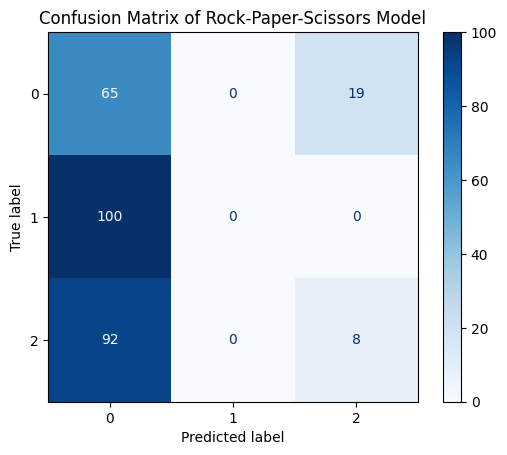

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 모델이 예측한 클래스 라벨 (확률에서 가장 높은 값 선택)
y_pred = model.predict(x_test_norm)
y_pred_labels = np.argmax(y_pred, axis=1)

# 혼동행렬 계산
cm = confusion_matrix(y_test, y_pred_labels)

class_names = [0, 1, 2]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Rock-Paper-Scissors Model')
plt.show()

In [31]:
# 동일 이미지가 있는지 확인 (픽셀 기준 비교)
overlap_count = 0
for i in range(len(x_test)):
    for j in range(len(x_train)):
        if np.array_equal(x_test[i], x_train[j]):
            overlap_count += 1
print("Train-Test 데이터 중복 개수:", overlap_count)

Train-Test 데이터 중복 개수: 0
